In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [2]:
import os
import json
import glob
import re

from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CNN.module.lib.layers import *
from Faraday.two_dim.module.lib.layers import *

from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.sqrt(x_train.astype("float32") / 255.0)
x_test = np.sqrt(x_test.astype("float32") / 255.0)

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
path = 'trained_model/20230110/intens/0'

outputs_idx = [2, 3, 5, 7, 9, 11, 13]

model = tf.keras.models.load_model(path)
outputs_idx = [2, 3, 5, 7, 9, 11, 13]
outputs = [ElectricFieldToIntensity((100, 100))(model.layers[i].output) for i in outputs_idx]

hidden_outs_model = tf.keras.Model(inputs=model.inputs, outputs=outputs)
hidden_pred = hidden_outs_model.predict(x_test[0:2, :, :])
pred = model.predict(x_test[0:2, :, :])
norm_pred = pred / np.max(pred, axis=1, keepdims=True)

raw_outs_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
raw_pred = raw_outs_model.predict(x_test[0:2,:,:])

detector = MNISTDetector.from_config(model.layers[-2].get_config())
detector.build((100, 100))
mask = detector.get_photo_mask()


1/1 [==============================] - 0s 357ms/step


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


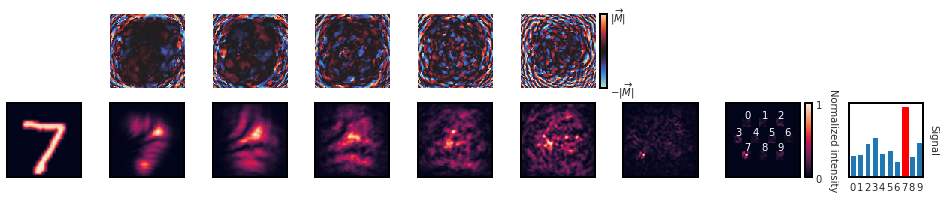

In [5]:
fig, axes = plt.subplots(2, len(outputs_idx)+2, figsize=(18,3))

for i in range(len(hidden_pred)):
    axes[1,i].imshow(hidden_pred[i][0,:,:] / np.max(hidden_pred[i][0,:,:]), vmin=0, vmax=1)
    axes[1,i].set_xticklabels([])
    axes[1,i].set_yticklabels([])

axes[1,-2].imshow(hidden_pred[-1][0,:,:]*mask/ np.max(hidden_pred[-1][0,:,:]*mask), vmin=0, vmax=1)
axes[1,-2].set_xticklabels([])
axes[1,-2].set_yticklabels([])

axes[1,-2].text(23,20, "$0$", color="white")
axes[1,-2].text(46,20, "$1$", color="white")
axes[1,-2].text(68,20, "$2$", color="white")
axes[1,-2].text(12,43, "$3$", color="white")
axes[1,-2].text(35,43, "$4$", color="white")
axes[1,-2].text(56.5,43, "$5$", color="white")
axes[1,-2].text(78,43, "$6$", color="white")
axes[1,-2].text(23,64, "$7$", color="white")
axes[1,-2].text(46,64, "$8$", color="white")
axes[1,-2].text(68,64, "$9$", color="white")
axes[1,-2].set_xticklabels([])
axes[1,-2].set_yticklabels([])

rect = axes[1,-1].bar(range(len(raw_pred[0,:])), raw_pred[0,:], align='center')
max_idx = np.argmax(raw_pred[0,:])
rect[max_idx].set_color("red")

labels = list(np.arange(0,10,1))
axes[1,-1].set_xticks(labels)
axes[1,-1].set_xticklabels(["${:d}$".format(l) for l in labels])
axes[1,-1].set_yticks([])
axes[1,-1].set_yticklabels([])

axes[1,-1].set_ylim(0, raw_pred[0,:][max_idx] * 1.05)

ax_pos1 = axes[1,-2].get_position()
ax_pos2 = axes[1,-1].get_position()
axes[1,-1].set_position([ax_pos2.x0, ax_pos1.y0, ax_pos1.width, ax_pos1.height])

cbar_ax = fig.add_axes([ax_pos1.x1+0.004, ax_pos1.y0, 0.005, ax_pos1.height])
cbar = fig.colorbar(axes[1, -2].images[0], cax=cbar_ax)
cbar.set_ticks([0,1])
cbar.set_ticklabels(["$0$", "$1$"])
cbar.set_label("Normalized intensity", rotation=270, labelpad=15)

axes[1, -1].set_ylabel("Signal", rotation=270, labelpad=15)
axes[1, -1].yaxis.set_label_position("right")

for ax in axes:
    ax_pos1 = ax[-1].get_position()
    ax[-1].set_position([ax_pos1.x0 + 0.02, ax_pos1.y0, ax_pos1.width, ax_pos1.height])

weights = model.get_weights()
for i in range(5):
    axes[0, i+1].imshow(np.pi*np.sin(weights[i]), cmap=sns.color_palette("icefire", as_cmap=True))
    axes[0,i+1].axis(False)

ax_pos1 = axes[0,5].get_position()
ax_pos2 = axes[0,6].get_position()
axes[0,6].set_position([ax_pos2.x0, ax_pos1.y0, ax_pos1.width, ax_pos1.height])

cbar_ax = fig.add_axes([ax_pos1.x1+0.004, ax_pos1.y0, 0.005, ax_pos1.height])
cbar = fig.colorbar(axes[0, 5].images[0], cax=cbar_ax)
cbar.set_ticks([-np.pi,np.pi])
cbar.set_ticklabels(["$-|\overrightarrow{M}|$", "$|\overrightarrow{M}|$"])
#cbar.set_label("Faraday rotation  (deg.)", rotation=270, labelpad=15)

fig.delaxes(axes[0,0])
fig.delaxes(axes[0,-1])
fig.delaxes(axes[0,-2])
fig.delaxes(axes[0,-3])

fig.savefig("out/paper/7/intens_hidden_out_and_pattern.png", dpi=300)

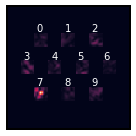

In [10]:
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ax.imshow(hidden_pred[-1][0,:,:]*mask/ np.max(hidden_pred[-1][0,:,:]*mask), vmin=0, vmax=1)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(23,20, "$0$", color="white")
ax.text(46,20, "$1$", color="white")
ax.text(68,20, "$2$", color="white")
ax.text(12,43, "$3$", color="white")
ax.text(35,43, "$4$", color="white")
ax.text(56.5,43, "$5$", color="white")
ax.text(78,43, "$6$", color="white")
ax.text(23,64, "$7$", color="white")
ax.text(46,64, "$8$", color="white")
ax.text(68,64, "$9$", color="white")
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig("out/paper/7/out222.png", dpi=300)

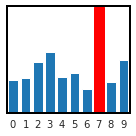

In [14]:
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
rect = ax.bar(range(len(raw_pred[0,:])), raw_pred[0,:], align='center')
max_idx = np.argmax(raw_pred[0,:])
rect[max_idx].set_color("red")

labels = list(np.arange(0,10,1))
ax.set_xticks(labels)
ax.set_xticklabels(["${:d}$".format(l) for l in labels])
ax.set_yticks([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig("out/paper/7/raw.png", dpi=300)

In [ ]:
for i in range(5):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.imshow(np.pi*np.sin(weights[i]), cmap=sns.color_palette("icefire", as_cmap=True))
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig("out/pattern/{0:2d}.png".format(i), dpi=300)